# Water Allocation Simulation Analysis
This notebook provides tools to analyze the results of the water allocation simulation
across multiple scenarios, focusing on ecological and economic impacts under different
conditions.

## Overview
The simulation tests water allocation policies across various scenarios with different:
- River basins (station configurations)
- Actor compositions (different archetypes from the paper)
- Water scarcity levels
- Forecast error profiles (bias and uncertainty)

The analysis evaluates how these factors affect both ecological integrity and economic benefits.


In this notebook we will:
1. Run the set of evaluation scenarios varying station size, scarcity level,  
   forecast bias and uncertainty.
2. Collect ecological and economic impact metrics for each run.
3. Visualize trade-offs and explore how model parameters influence outcomes.

In [7]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from types import MethodType
import src.core as wms
import src.plot_analysis as gtp
import src.utils as utils
import src.policies.incentive_policies as eip
import src.policies.quota_policies as eqp
import src.scenarios as sc
import src.utils as utils
import src.plot_multi_analysis as pma
import src.policies.incentive_policies as eip
import src.policies.quota_policies as eqp

# Set better visualization defaults
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

In [8]:
# define your custom quota policy 
def custom_quota(self, 
                crisis_level: int, # for testing purposes only you can't use it in your final policy
                actors_priority: np.ndarray,
                avg_pump: np.ndarray,
                DOE: float,
                DCR: float) -> np.ndarray:
    """
    Compute the quota for each actor based on the crisis level.
    
    Parameters:
    -----------
    crisis_level : int
        Current water crisis level (-1: Normal, 0: Alert, 1: High-Alert, 2: Crisis)
    actors_priority : np.ndarray
        Priority level of each actor (2: High, 1: Medium, 0: Low)
    avg_pump : np.ndarray
        Average water pumped by each actor over the past year
    DOE : float
        Objective Low-Water Flow threshold
    DCR : float
        Crisis Flow threshold
        
    Returns:
    --------
    np.ndarray
        Array of quotas for each actor
    """
    # Default implementation: use hard quota policy from example
    quota = eqp.hard_quota(self, crisis_level, actors_priority, avg_pump, DOE, DCR)
    return quota

# or use the example incentive policy
# custom_quota = eqp.hard_quota

In [9]:
# Define quota policy - determines how much water each actor is allowed to pump
# This uses the hard_quota policy from the quota_policies module
# In crisis situations, actors with priority below the crisis level get zero quota
custom_quota = eqp.hard_quota

# Define incentive policy - uses fines and subsidies to influence actor behavior
def custom_incentive_policy(self,
                    actions: np.ndarray,
                    actors_priority: np.ndarray,
                    avg_incomes: np.ndarray,
                    water_pump: np.ndarray,
                    avg_pump: np.ndarray,
                    is_crisis: np.ndarray,
                    water_flows: np.ndarray,
                    quota: np.ndarray,
                    DOE = 15,
                    DCR = 10) -> np.ndarray:
    """
    Custom incentive policy that applies fines for exceeding quota and subsidies for cooperation.
    
    Returns an array of incentives (positive values = fines, negative values = subsidies)
    """
    fine = np.zeros(self.nb_actors)
    stress = is_crisis[-1]  # Current crisis level
    
    # If average income is negative, replace it with 0
    avg_incomes = np.where(avg_incomes < 0, 0, avg_incomes)
    
    for i in range(self.nb_actors):
        # Apply heavy fine if exceeding quota during crisis
        if (water_pump[i] > quota[i]) and (actors_priority[i] <= stress):
            fine[i] = 8
        # Give small subsidy to low priority actors who respect their quota
        elif (water_pump[i] <= quota[i]) and (actors_priority[i] < stress):
            fine[i] = -(avg_incomes[i] * 50)
    return fine

## Scenario Definition
Runs simulations across the pre-defined scenarios.
We iterate over:
- **Stations**: Tarn vs. La Vézère  
- **Scarcity levels**: low / medium / high  
- **2 set of actors and variant with heterogenous biaises and uncertainties**  
- **Forecast bias/uncertainty** settings  

Execute the next cell to proceed multo-scenario analysis.

In [10]:
if True:
    results_df = sc.run_all_scenarios(
        turns=700,
        iterations=10,
        custom_incentive_policy=custom_incentive_policy,
        custom_quota=custom_quota)


Starting simulations across all scenarios...
Scenario: 0.yml, Station: 1, Scarcity: low, Bias: 0.0, Uncertainty: 0.0, Eco Impact: 0.684, Econ Impact: -0.365, Raw Eco Impact: 1353.0, Cooperation %: 95.0%
Scenario: 0.yml, Station: 1, Scarcity: low, Bias: 0.0, Uncertainty: 0.25, Eco Impact: 0.683, Econ Impact: -0.368, Raw Eco Impact: 1350.0, Cooperation %: 94.9%
Scenario: 0.yml, Station: 1, Scarcity: low, Bias: 0.0, Uncertainty: 0.5, Eco Impact: 0.679, Econ Impact: -0.264, Raw Eco Impact: 1343.0, Cooperation %: 95.2%
Scenario: 0.yml, Station: 1, Scarcity: low, Bias: 0.25, Uncertainty: 0.0, Eco Impact: 0.679, Econ Impact: -0.087, Raw Eco Impact: 1344.0, Cooperation %: 95.8%
Scenario: 0.yml, Station: 1, Scarcity: low, Bias: 0.25, Uncertainty: 0.25, Eco Impact: 0.683, Econ Impact: 0.025, Raw Eco Impact: 1350.0, Cooperation %: 96.5%
Scenario: 0.yml, Station: 1, Scarcity: low, Bias: 0.25, Uncertainty: 0.5, Eco Impact: 0.683, Econ Impact: -0.477, Raw Eco Impact: 1350.0, Cooperation %: 94.7%
Sce


## Multi-Scenario Analysis


Save the results if needed.

In [11]:
# save results_df to csv
results_df.to_csv('results_df.csv', index=False)

# load results_df from csv
results_df = pd.read_csv('results_df.csv')


### Ecological vs. economic impact.

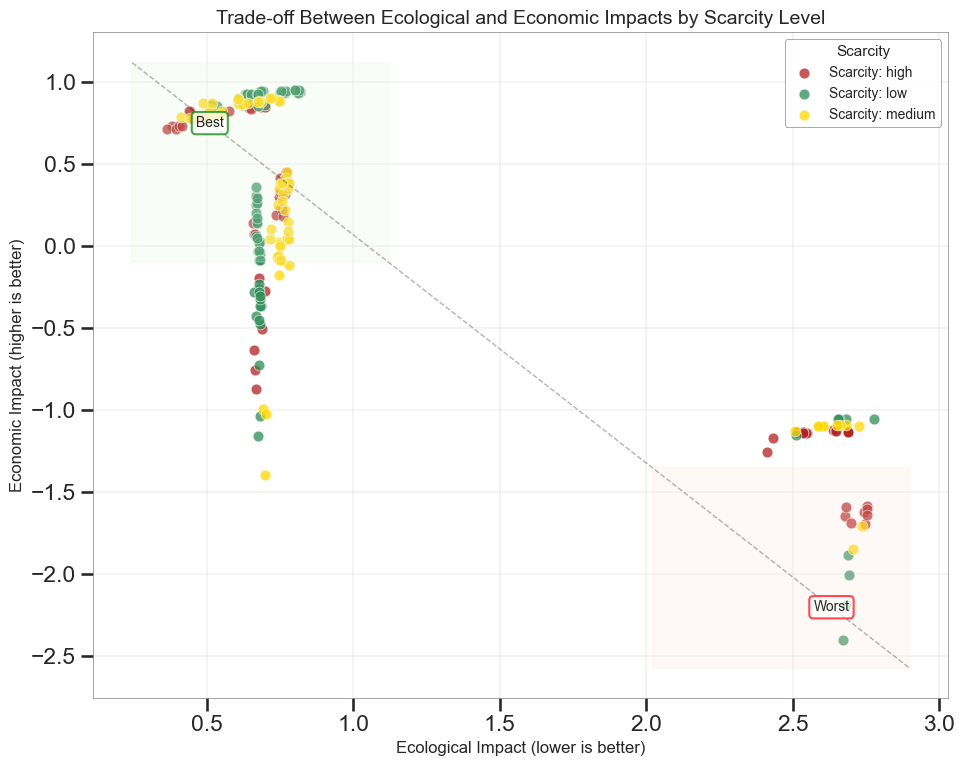

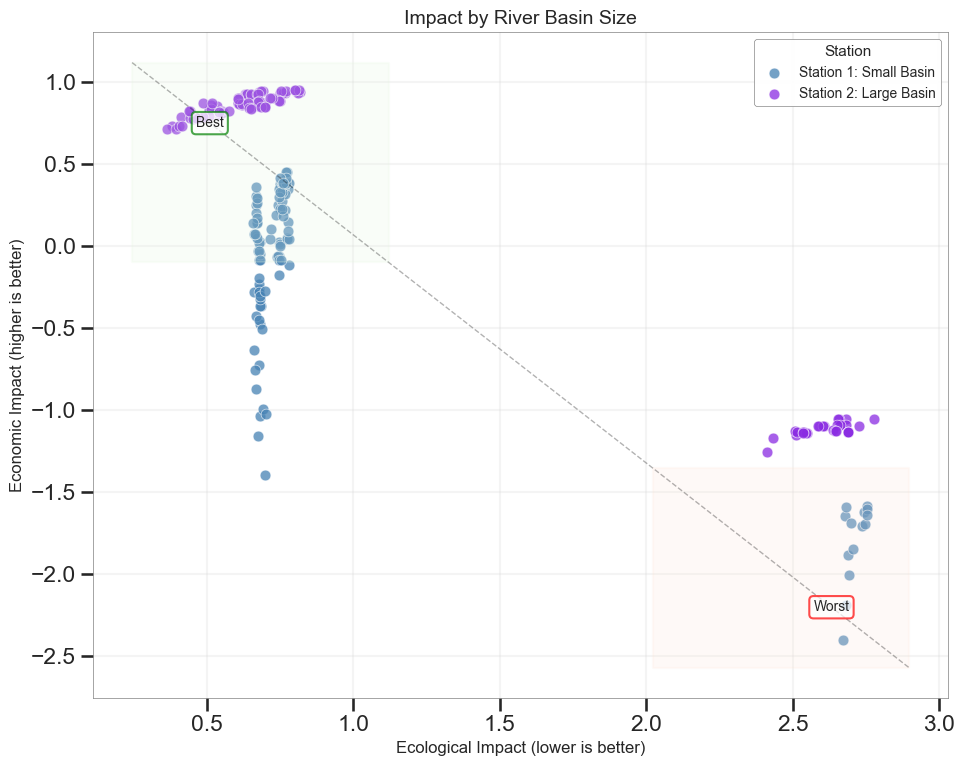

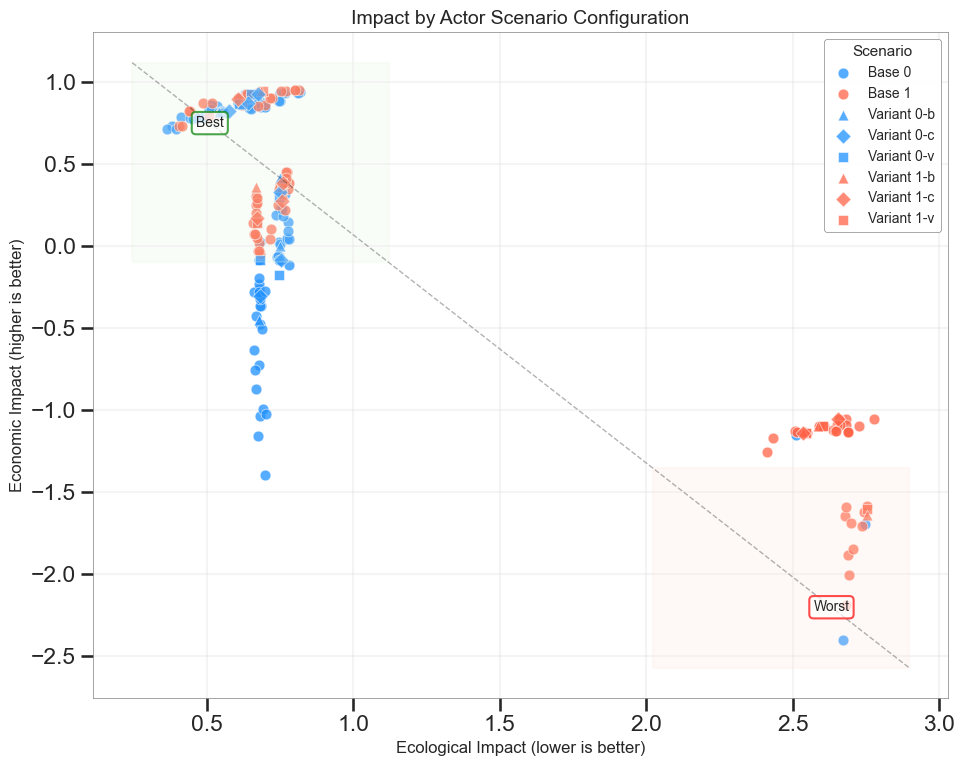

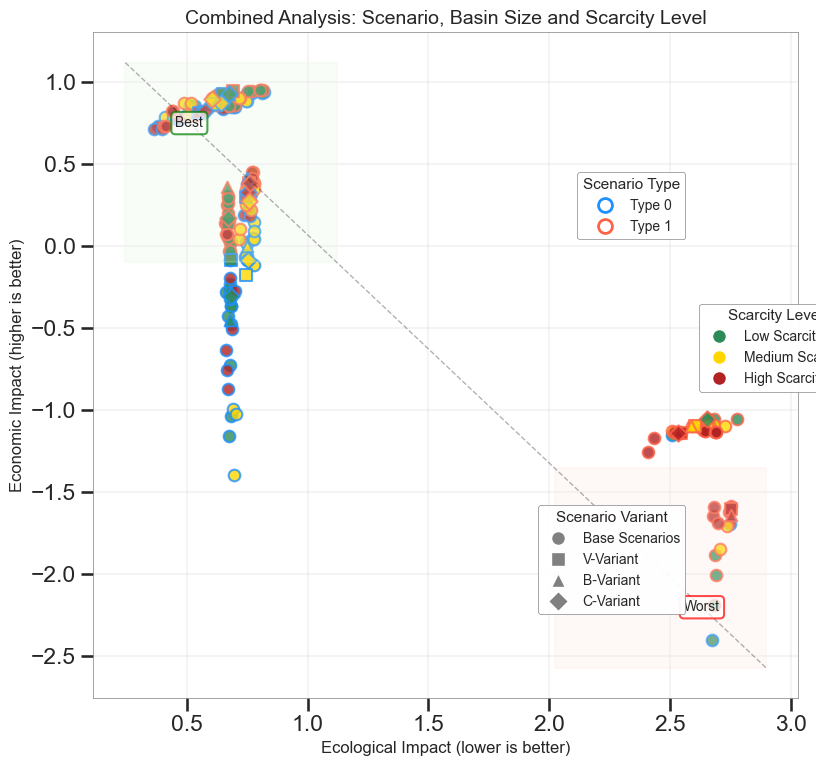

In [12]:
pma.analyze_scenario_impacts(results_df)

## Analyzing Forecast Bias & Uncertainty & Scarcity levels

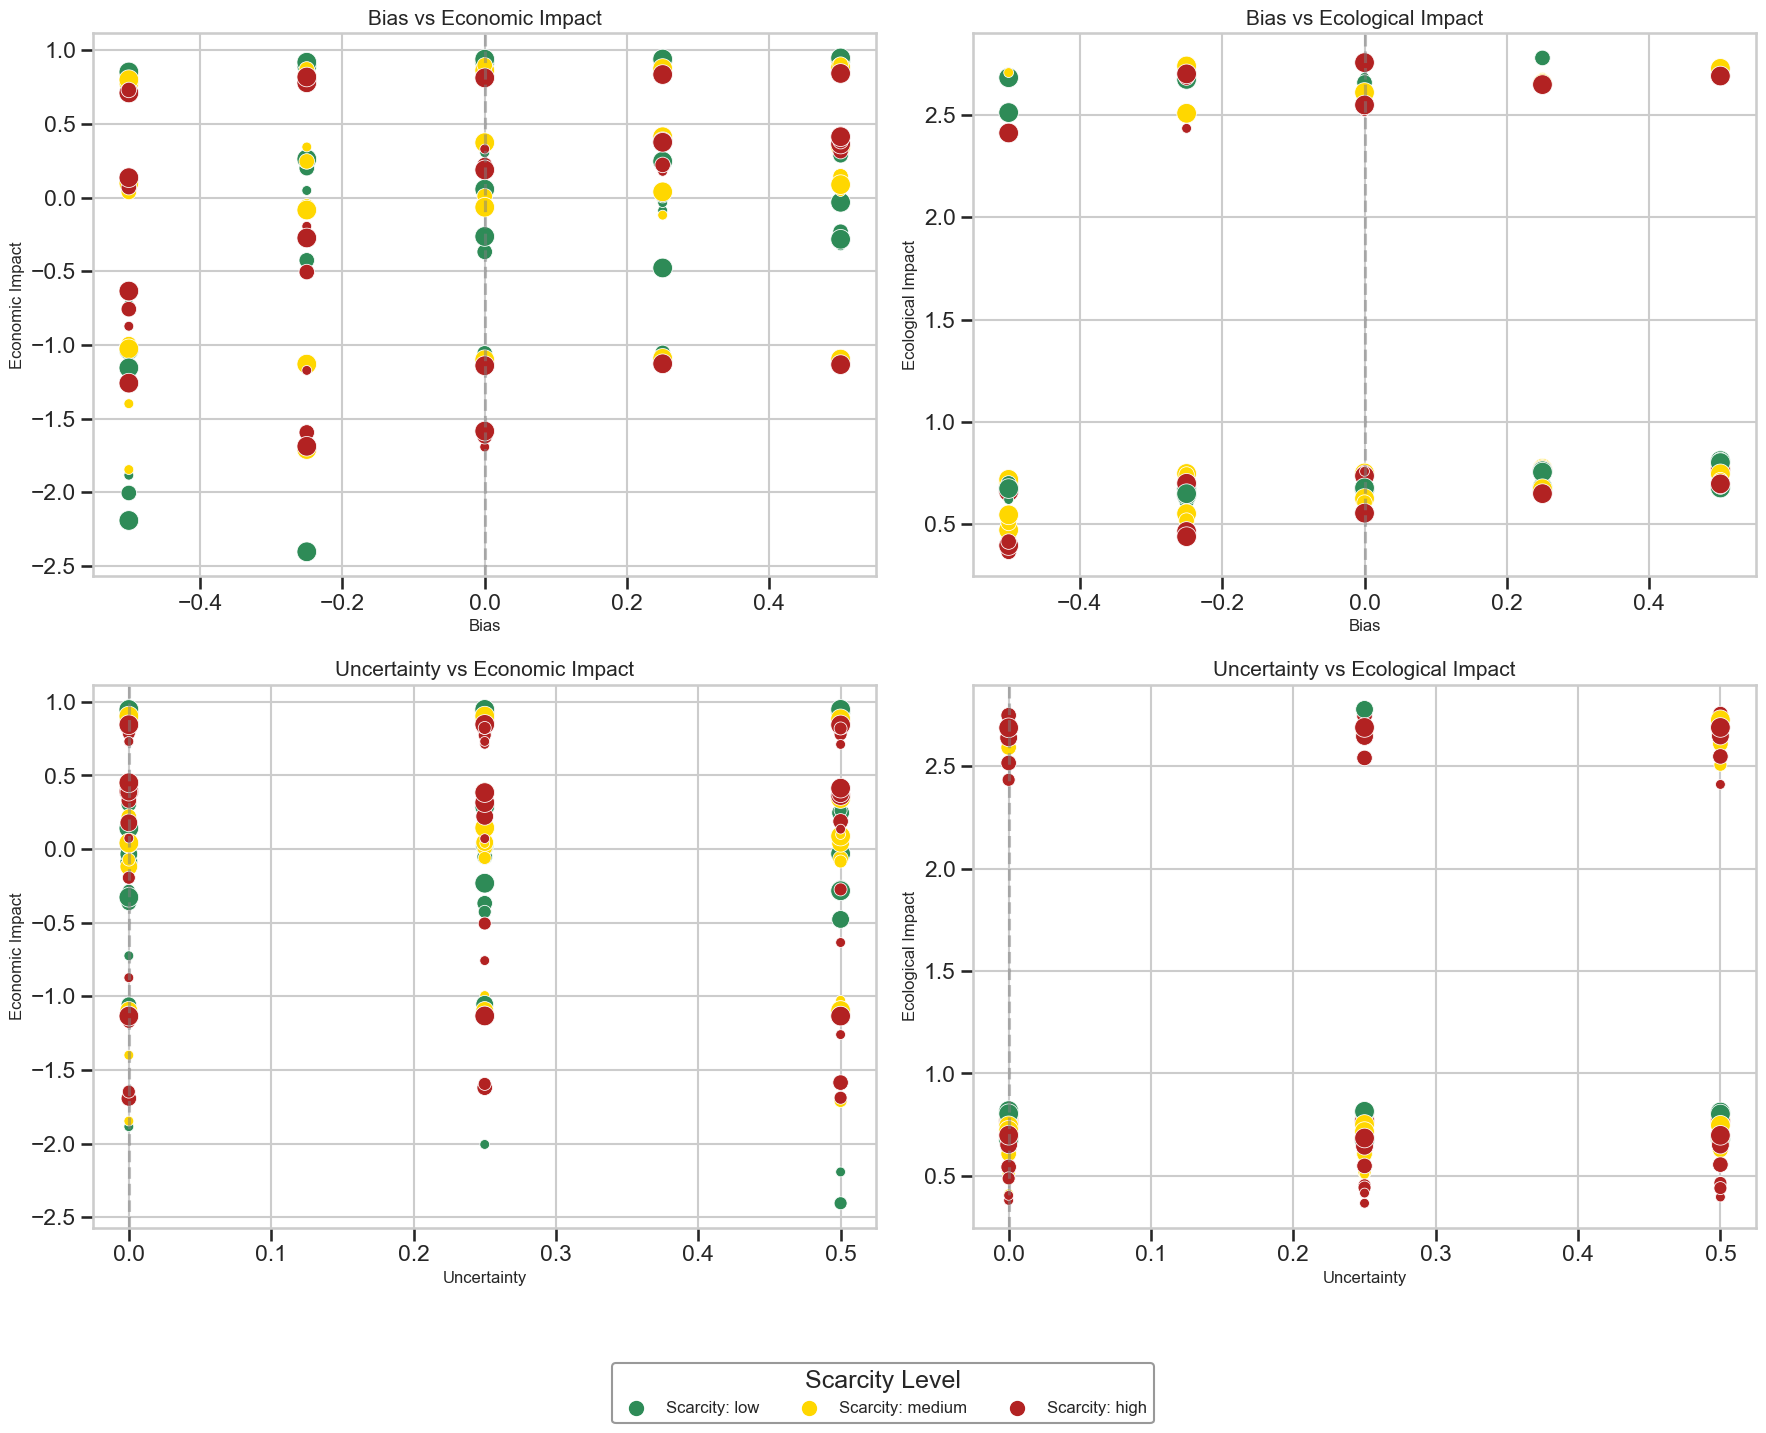

c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon.Phase2\WaterScarcity.Hackathon\src\plot_multi_analysis.py:318: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon.Phase2\WaterScarcity.Hackathon\src\plot_multi_analysis.py:318: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


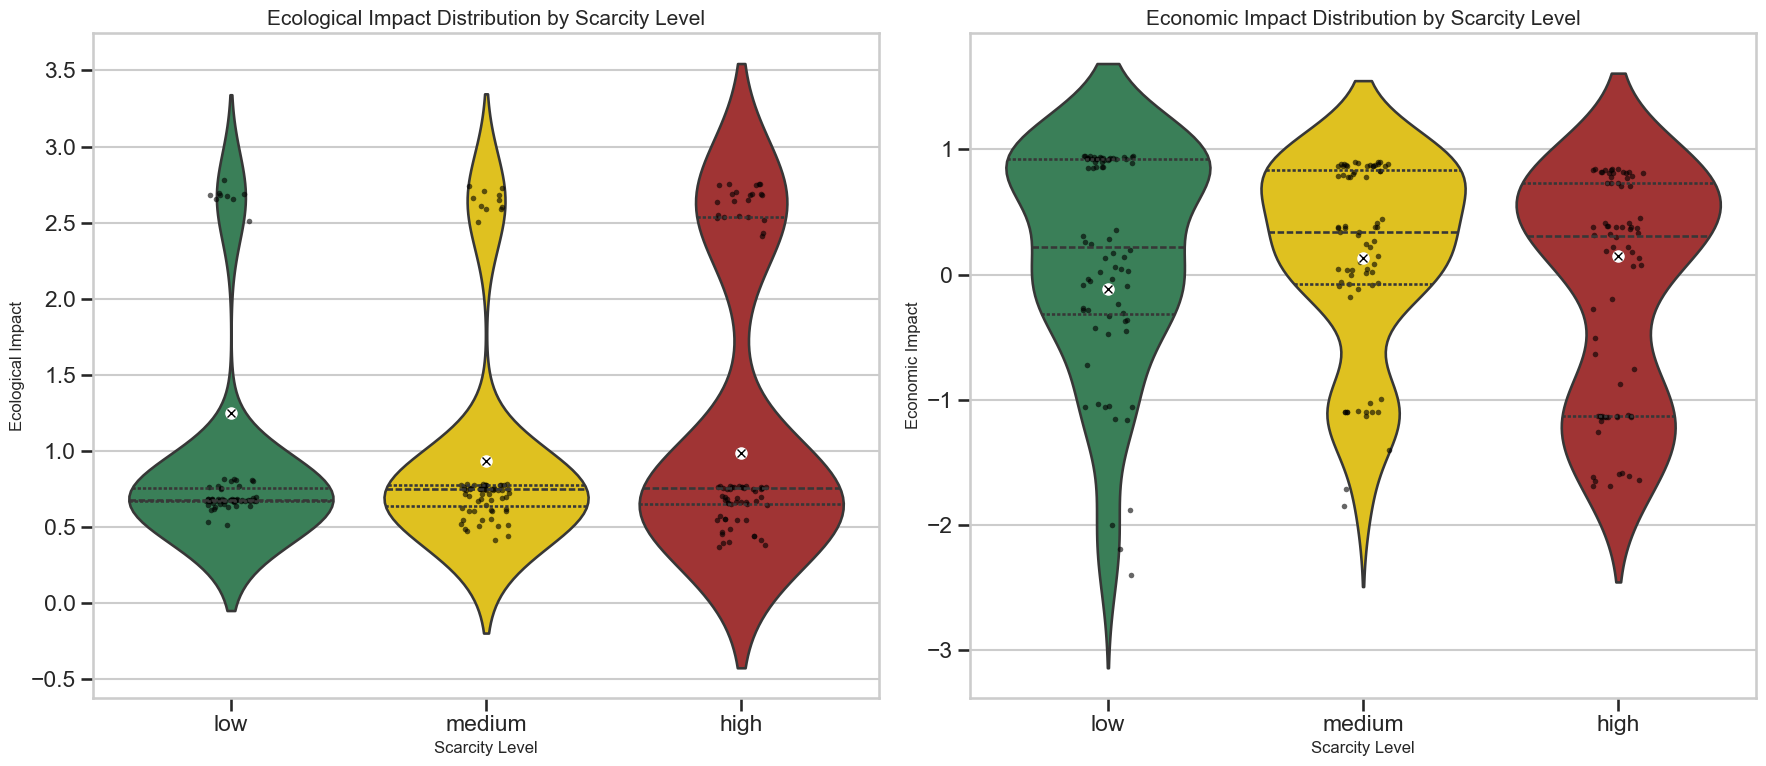

In [13]:
pma.analyze_forecast_effects(results_df)

## Correlation Analysis


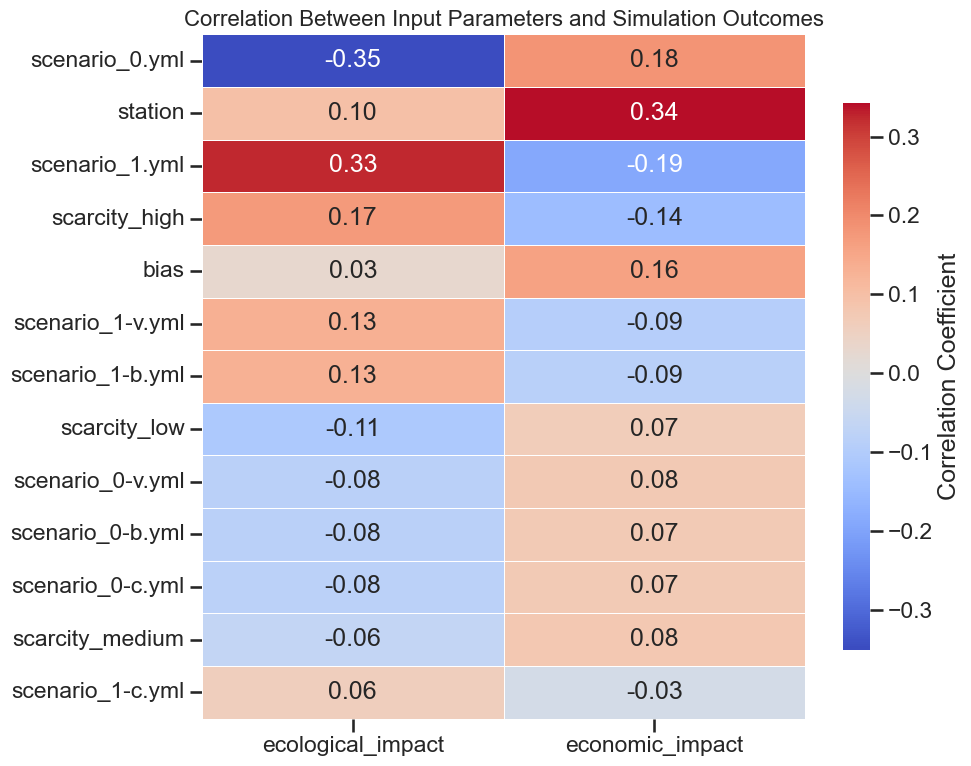


Top impacts on ecological_impact:

Top 5 positive correlations:
  scenario_1.yml: 0.326
  scarcity_high: 0.175
  scenario_1-v.yml: 0.132
  scenario_1-b.yml: 0.131
  station: 0.098

Top 5 negative correlations:
  scenario_0-c.yml: -0.081
  scenario_0-b.yml: -0.083
  scenario_0-v.yml: -0.084
  scarcity_low: -0.110
  scenario_0.yml: -0.351

Top impacts on economic_impact:

Top 5 positive correlations:
  station: 0.343
  scenario_0.yml: 0.183
  bias: 0.161
  scarcity_medium: 0.078
  scenario_0-v.yml: 0.076

Top 5 negative correlations:
  uncertainty: -0.045
  scenario_1-b.yml: -0.087
  scenario_1-v.yml: -0.091
  scarcity_high: -0.143
  scenario_1.yml: -0.189


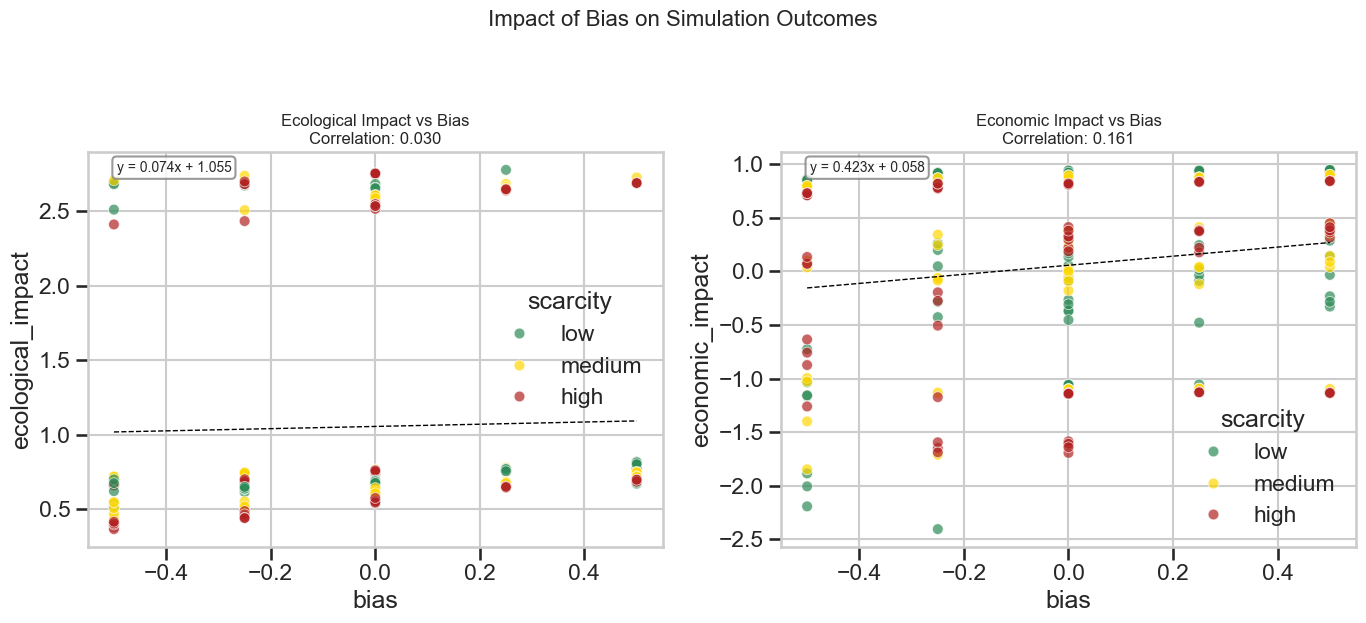

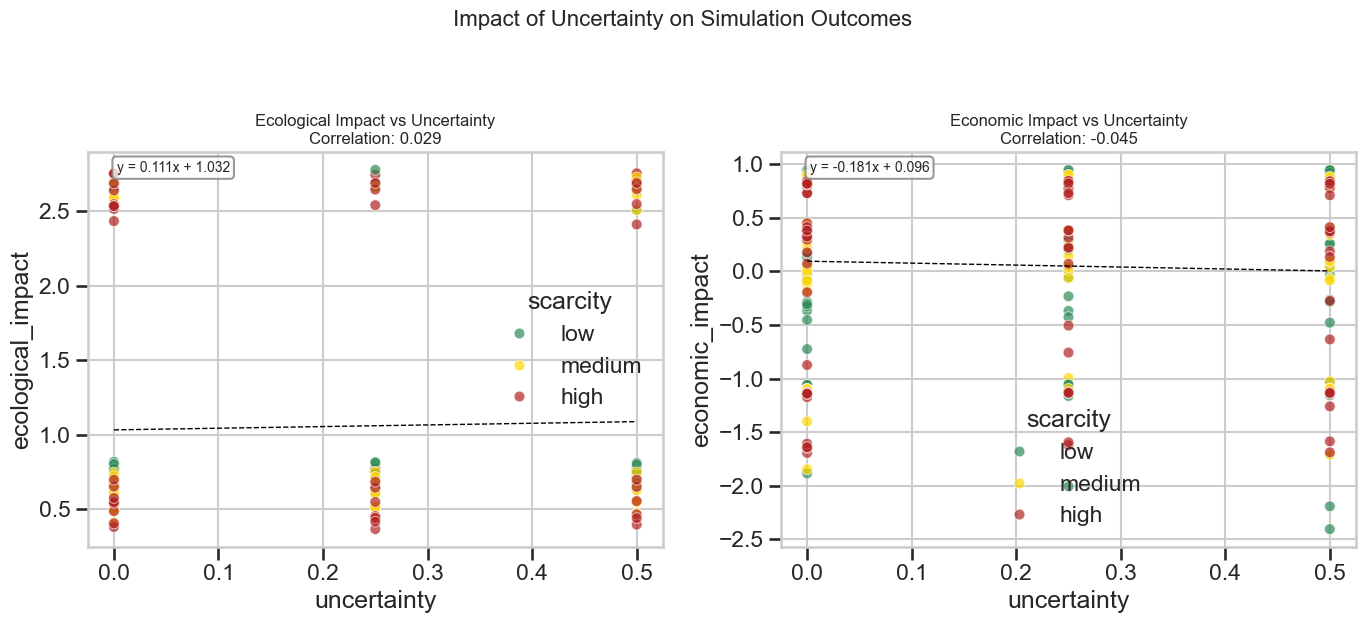

<Figure size 1200x1000 with 0 Axes>

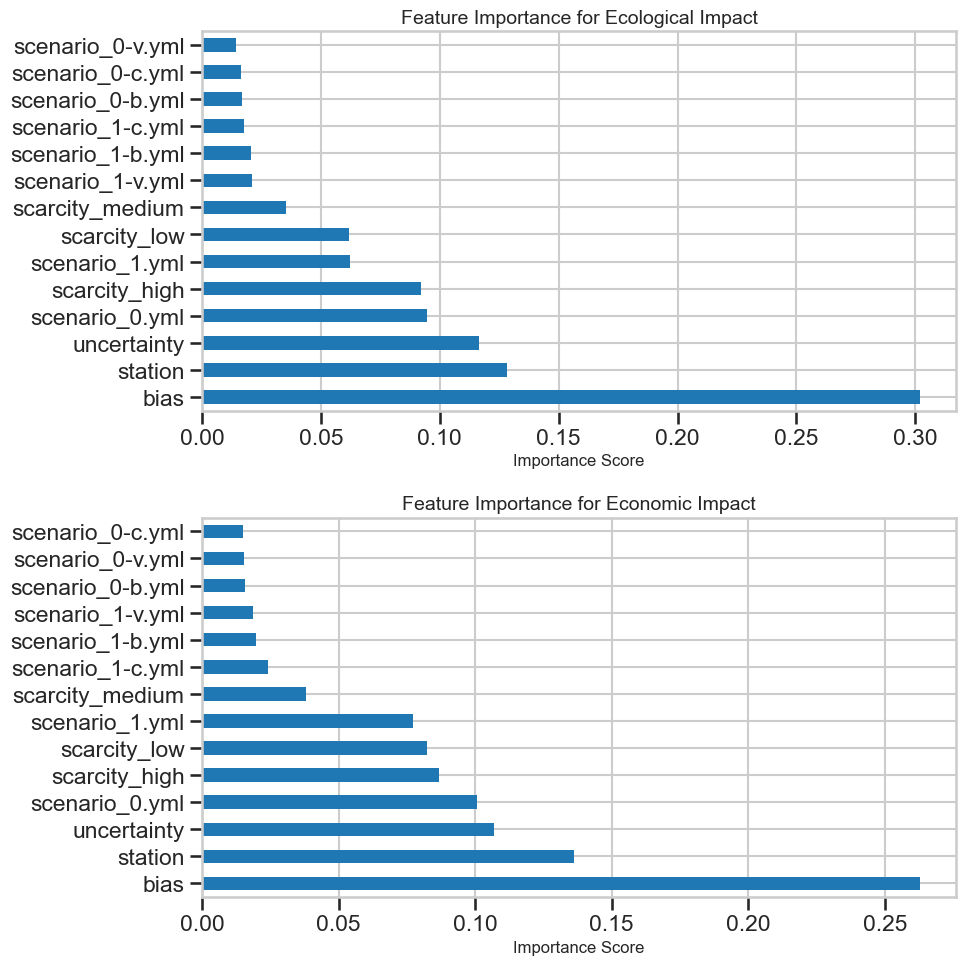

In [14]:
pma.correlation_analysis(results_df)

## Cooperation Analysis
Analyzing cooperation patterns across scenarios and their impact on ecological and economic outcomes.

c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon.Phase2\WaterScarcity.Hackathon\src\plot_multi_analysis.py:920: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


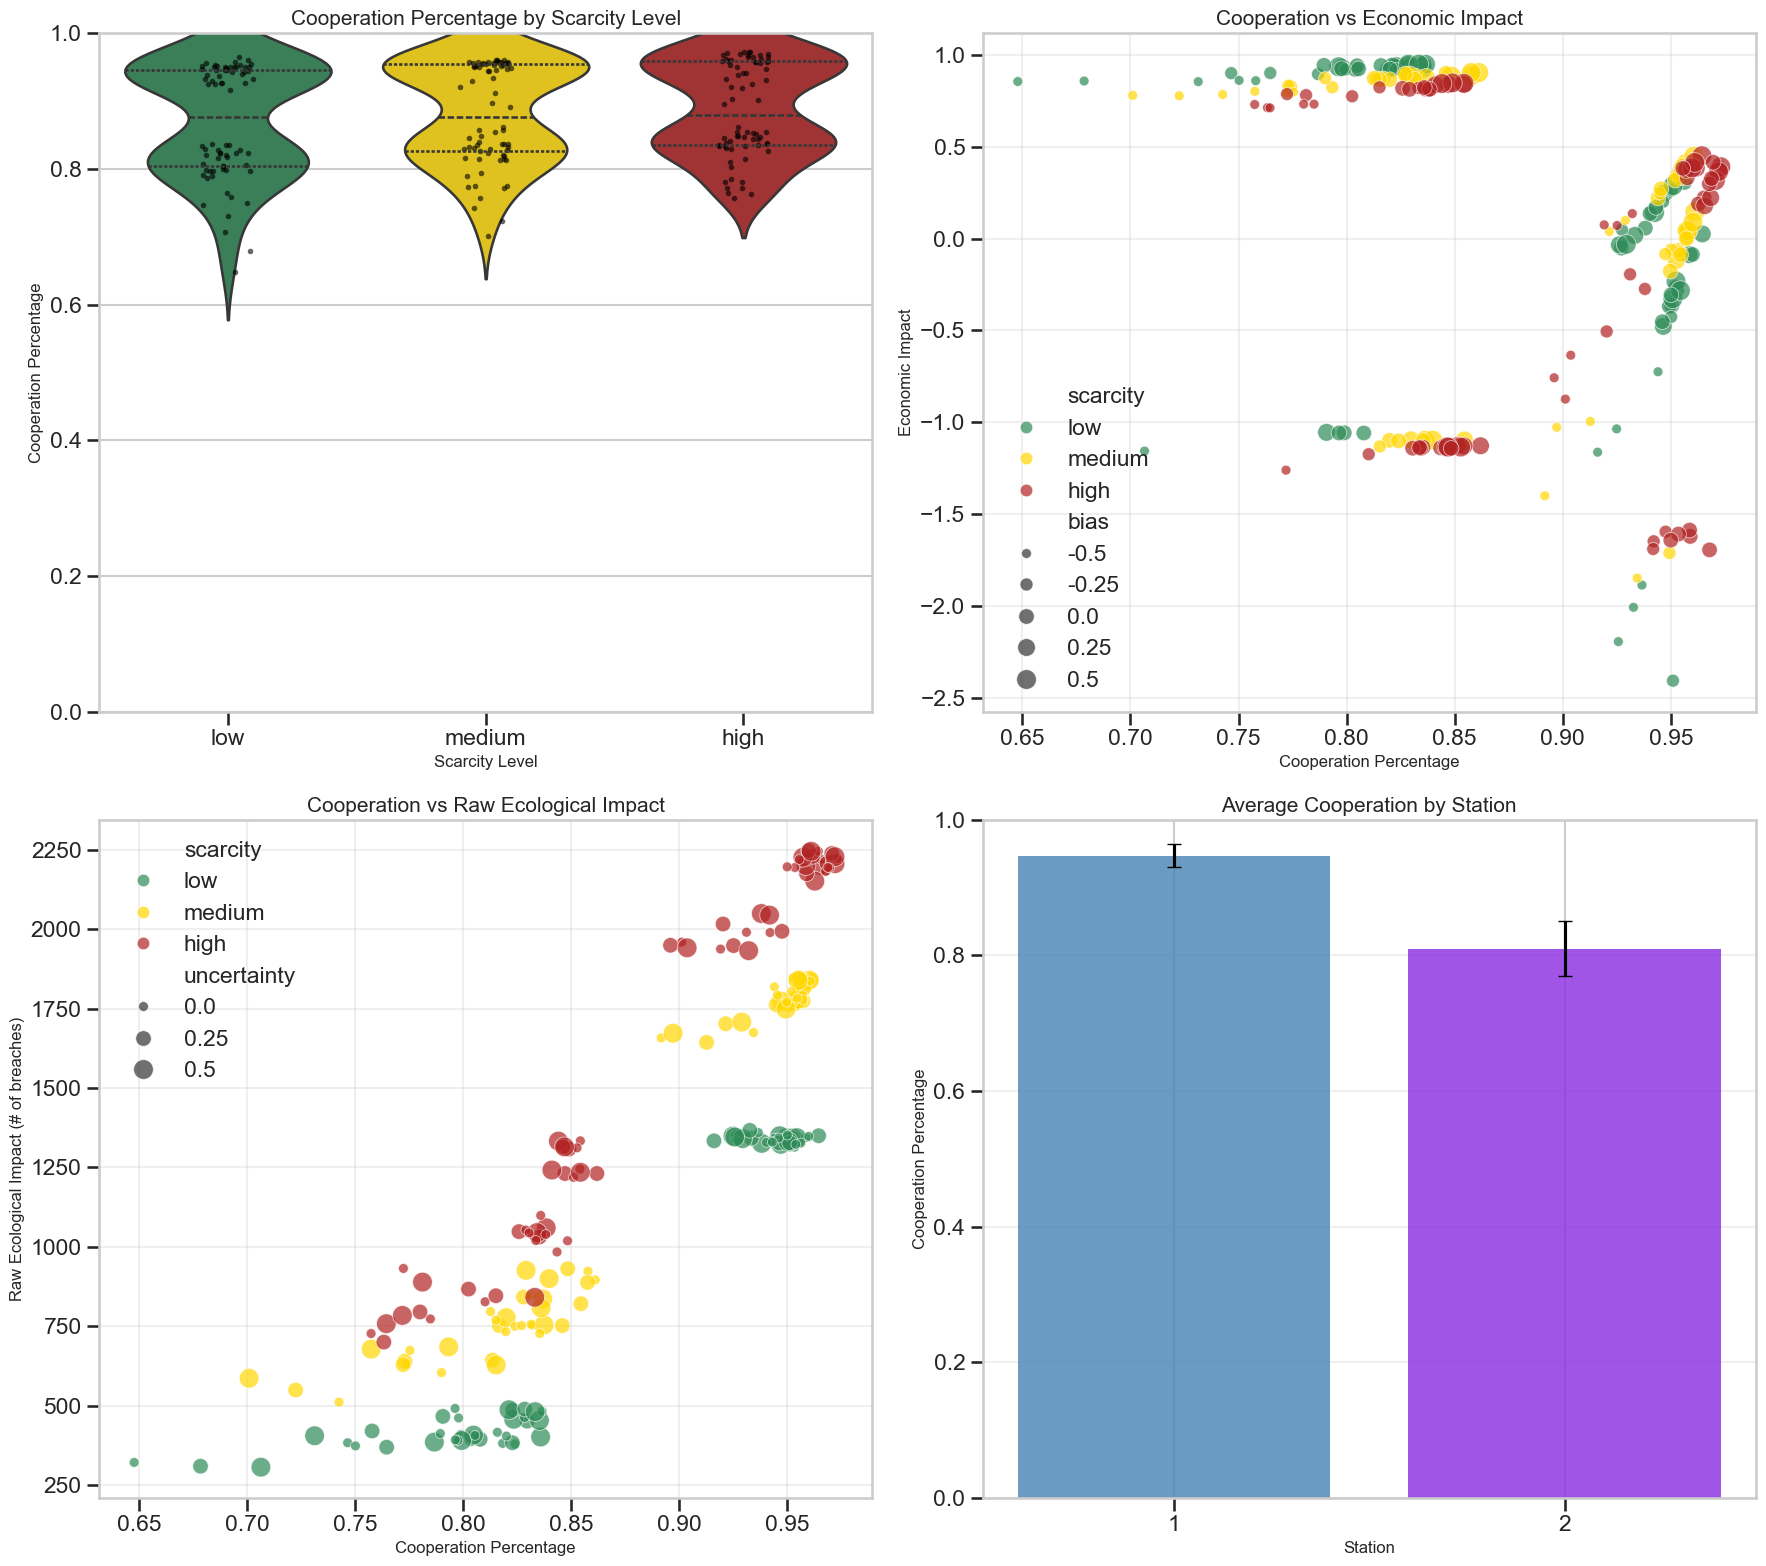

In [15]:
pma.analyze_cooperation_patterns(results_df)

## Raw Ecological Impact Analysis
Analyzing the raw (unscaled) ecological impact across different scenarios.

c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon.Phase2\WaterScarcity.Hackathon\src\plot_multi_analysis.py:1032: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon.Phase2\WaterScarcity.Hackathon\src\plot_multi_analysis.py:1066: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


1
2
{'1': '#4682B4', '2': '#8A2BE2'}


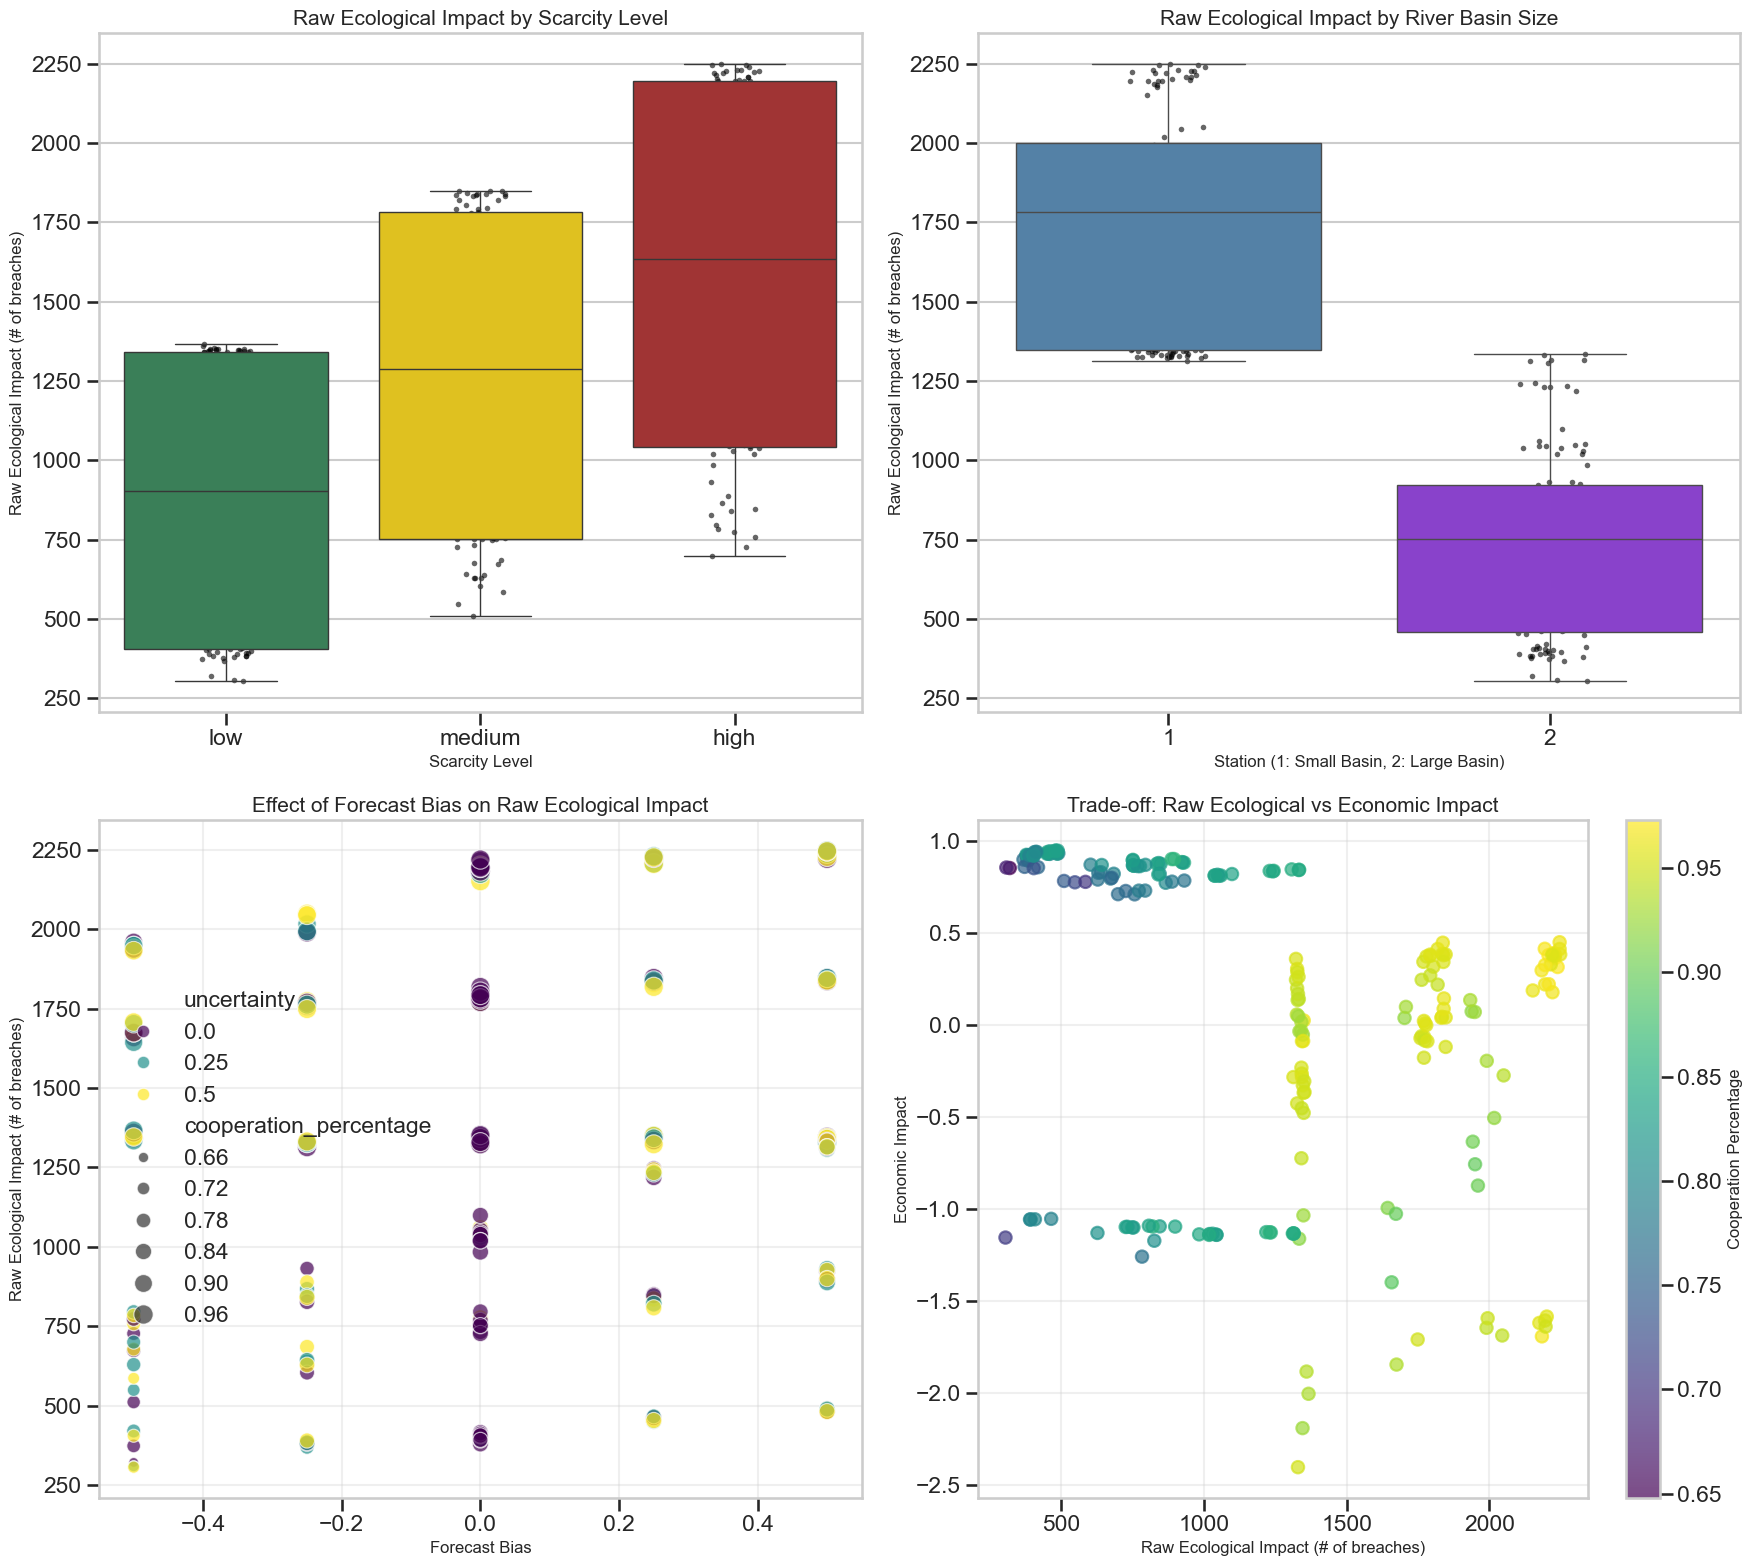

In [16]:
pma.analyze_raw_ecological_impact(results_df)

## Cooperation by Forecast Parameters
Analyzing how forecast bias and uncertainty affect cooperation levels.


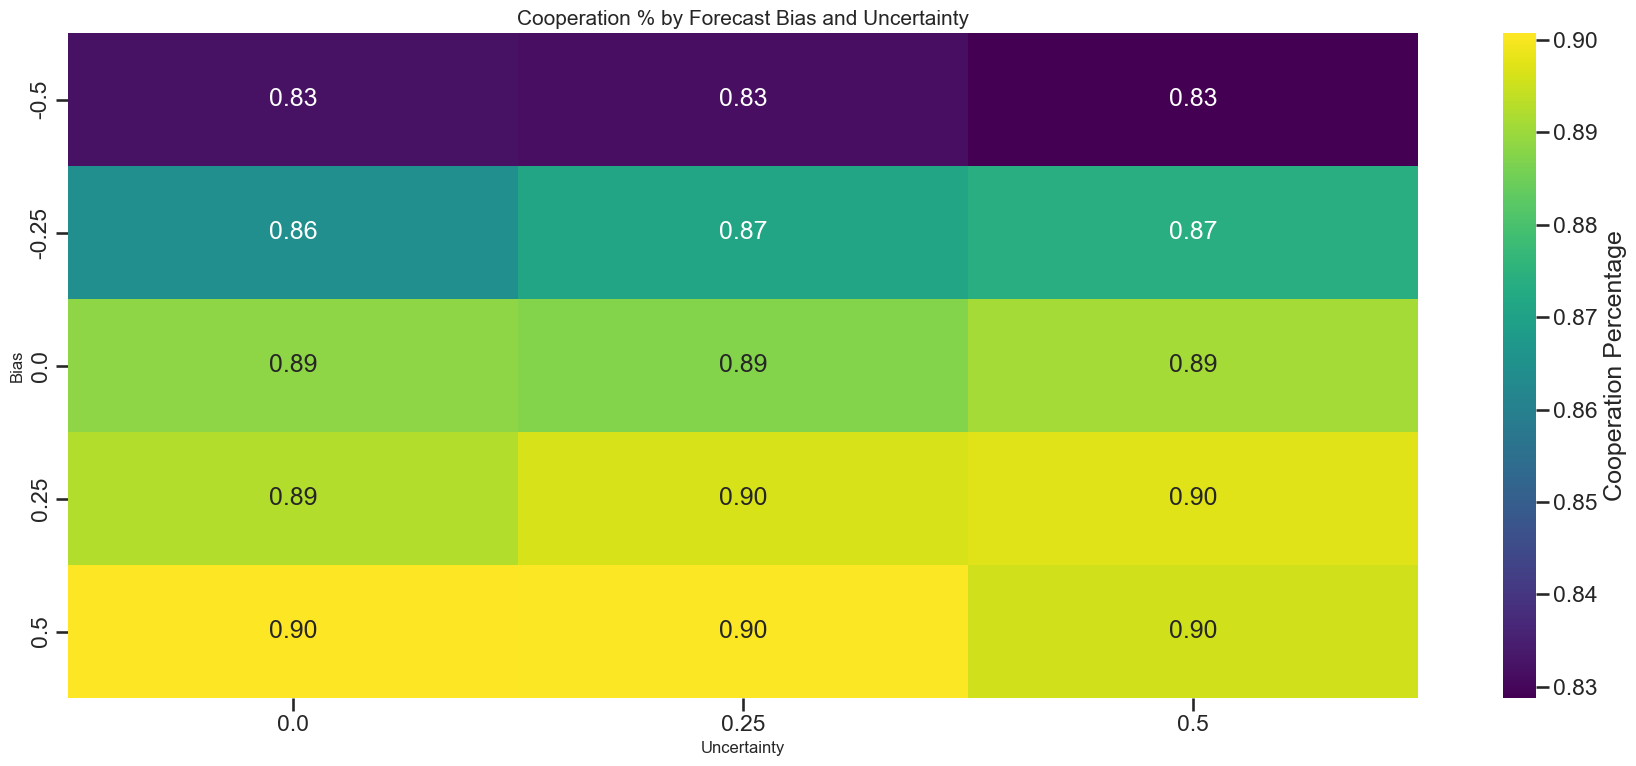

In [17]:
pma.analyze_cooperation_by_forecast_params(results_df)

## Comprehensive Analysis
Performing a comprehensive analysis of all metrics and their relationships.


=== Summary Statistics ===

Overall Metrics:
Average Cooperation: 0.88
Average Raw Ecological Impact: 1243.4 breaches
Average Scaled Ecological Impact: 1.055
Average Economic Impact: 0.058

Correlation Matrix:
                        cooperation_percentage  raw_ecological_impact  \
cooperation_percentage                    1.00                   0.87   
raw_ecological_impact                     0.87                   1.00   
ecological_impact                        -0.00                   0.02   
economic_impact                          -0.33                  -0.33   
bias                                      0.28                   0.14   
uncertainty                              -0.02                  -0.00   

                        ecological_impact  economic_impact  bias  uncertainty  
cooperation_percentage              -0.00            -0.33  0.28        -0.02  
raw_ecological_impact                0.02            -0.33  0.14        -0.00  
ecological_impact                    1

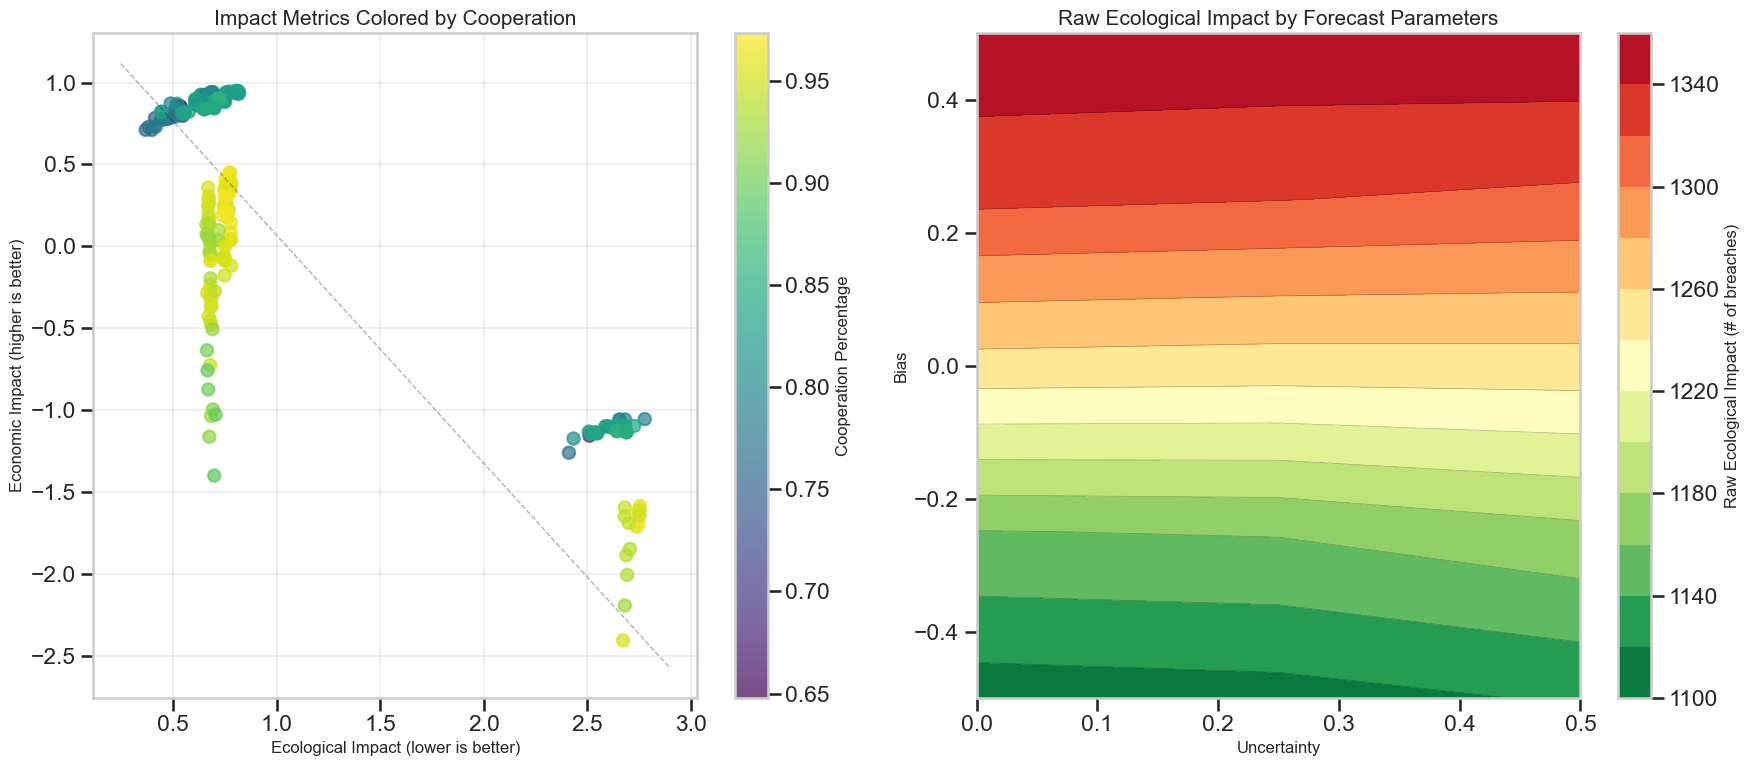

In [18]:
pma.comprehensive_analysis(results_df)

## Conclusion
This notebook has demonstrated how to analyze water allocation policies across multiple scenarios,
focusing on the balance between ecological and economic impacts. To participate in the hackathon:

1. Design your own adaptive policy by modifying the `custom_incentive_policy` and `custom_quota` functions
2. Test your policy across multiple scenarios using the tools provided
3. Optimize your policy to balance ecological integrity and economic benefits

Good luck!